In [1]:
%load_ext autoreload
%autoreload 
    
import time
import sys
sys.path.insert(0, "../")

from leitmotifs.plotting import *
from leitmotifs.lama import *

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

colors = sns.color_palette("tab10")

def plot_motiflet(series, motiflet, dims, motif_length, title=None):    
    fig, ax = plt.subplots(figsize=(4,2))

    offset = 0.0
    for dim in dims:
        dim_data_raw = pd.DataFrame(data=np.array([series[dim, i:i+motif_length] for i in motiflet]))        
        offset -= 2 * (dim_data_raw.values.max() - dim_data_raw.values.min())
        ax = sns.lineplot(data=dim_data_raw.melt().set_index("variable") + offset)
        
    if title:
        ax.set_title(title)
        
    sns.despine()
    fig.patch.set_visible(False)
    ax.legend().set_visible(False)
    ax.axis('off')
    return fig, ax


def find_dominant_window_sizes(X, offset=0.05):
    """Determine the Window-Size using dominant FFT-frequencies."""
    fourier = np.absolute(np.fft.fft(X))
    freqs = np.fft.fftfreq(X.shape[0], 1)

    coefs = []
    window_sizes = []

    for coef, freq in zip(fourier, freqs):
        if coef and freq > 0:
            coefs.append(coef)
            window_sizes.append(1 / freq)

    coefs = np.array(coefs)
    window_sizes = np.asarray(window_sizes, dtype=np.int64)

    idx = np.argsort(coefs)[::-1]
    return next(
        (
            int(window_size / 2)
            for window_size in window_sizes[idx]
            if window_size in range(20, int(X.shape[0] * offset))
        ),
        window_sizes[idx[0]],
    )


def load_dataset(dataset, selection=None):
    desc_filename = f"../datasets/{dataset}/desc.txt"
    desc_file = []

    with open(desc_filename, 'r') as file:
        for line in file.readlines(): desc_file.append(line.split(","))

    df = []

    for idx, row in enumerate(desc_file):
        if selection is not None and idx not in selection: continue
        (ts_name, window_size), change_points = row[:2], row[2:]
        if len(change_points) == 1 and change_points[0] == "\n": change_points = list()
        path = f'../datasets/{dataset}/'

        if os.path.exists(path + ts_name + ".txt"):
            ts = np.loadtxt(fname=path + ts_name + ".txt", dtype=np.float64)
        else:
            ts = np.load(file=path + "data.npz")[ts_name]

        df.append((ts_name, int(window_size), np.array([int(_) for _ in change_points]), ts))

    return pd.DataFrame.from_records(df, columns=["name", "window_size", "change_points", "time_series"])


def plot_data(series, annotations, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(20, 5))
    
    tick_offsets = []
    first_label = {}
    offset = 0
    for dim in range(series.shape[0]):
        for i, (a, b) in enumerate(zip(cps[:-1], cps[1:])):
            dim_data = series.iloc[dim, a:b]
            label = annotations[i]    
            c = colors[mapping[label] % len(colors)]
            if not label in first_label:
                first_label[label] = label
                sns.lineplot(x=np.arange(a,b), linewidth=1, y=dim_data+offset, ax = ax, label=label, color=c)
            else: 
                sns.lineplot(x=np.arange(a,b), linewidth=1, y=dim_data+offset, ax = ax, color=c)
            ax.axvline(x=b, color="black", linestyle="--", linewidth=1)    
        tick_offsets.append(offset)
        offset -= 1.2 * (series.iloc[dim].values.max() - series.iloc[dim].values.min())    
    
    ax.set_yticks(tick_offsets)
    ax.set_yticklabels(y_labels)
    ax.set_ylabel("")
    sns.despine()
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=10, fontsize=12)
    
    # ax.legend().set_visible(False)
    # ax.axis('off')
    plt.tight_layout()


# Loading the PAMAP dataset

The dataset comes from https://www.pamap.org/demo.html. Unfortunately, the archive is offline. The data contains outdoor and indoor routines performed by different subjects. Next, we will select the Outdoor routines performed by subject 8

In [2]:
dataset = "PAMAP"
# selection = [63, 64, 65] # Indoor
selection = [126, 127, 128] # Outdoor
df_data = load_dataset(dataset)

ts_name = df_data["name"].iloc[selection]
ts = df_data.time_series.iloc[selection]
cps = df_data.change_points.iloc[selection[0]]

X = np.zeros((len(ts.values), len(ts.values[0])))
for i, data in enumerate(ts.values):
    X[i] = data

cps = np.concatenate([[0], cps, [X.shape[1]]])

series = pd.DataFrame(data=X, index=ts_name)
series.rename(index={'PAMAP_Outdoor_Subject8_IMU_Shoe_X-Acc': 'Shoe X-Acc', 
                     'PAMAP_Outdoor_Subject8_IMU_Shoe_Y-Acc': 'Shoe Z-Acc', 
                     'PAMAP_Outdoor_Subject8_IMU_Shoe_Z-Acc': 'Shoe Y-Acc'}, inplace=True)

series.head()

,0,1,2,3,4,5,6,7,8,9,...,173865,173866,173867,173868,173869,173870,173871,173872,173873,173874
name,,,,,,,,,,,,,,,,,,,,,
Shoe X-Acc,-4.56,-4.64,-4.52,-4.60,-4.60,-4.52,-4.64,-4.64,-4.67,-4.67,...,-4.34,-4.45,-4.45,-4.49,-4.67,-4.67,-4.60,-4.49,-4.49,-4.45
Shoe Z-Acc,0.29,0.29,0.25,0.21,0.21,0.25,0.25,0.21,0.25,0.29,...,0.21,0.21,0.14,-0.05,0.21,0.21,0.21,0.10,0.21,0.21
Shoe Y-Acc,8.40,8.32,8.56,8.52,8.40,8.48,8.40,8.44,8.52,8.40,...,8.56,8.48,8.60,8.72,8.48,8.52,8.40,8.56,8.52,8.56


# Annotations

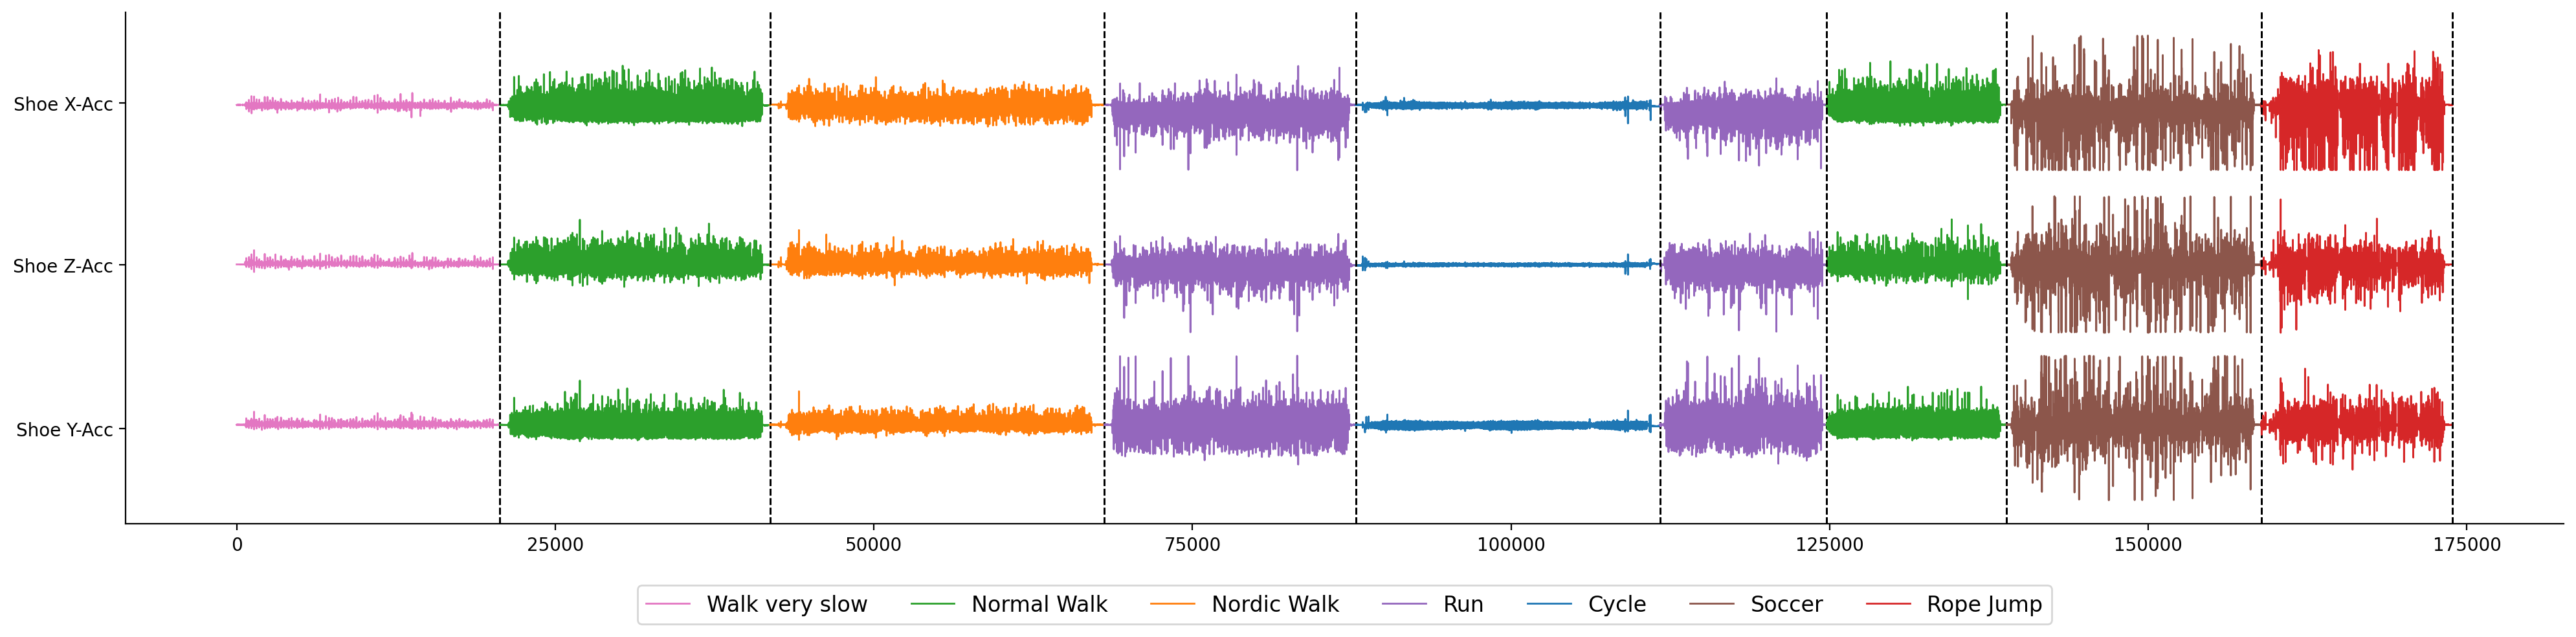

In [3]:
indoor_annotations = ["Lie", "Sit", "Stand", "Iron", "Vacuum", "Ascend Stairs",  "Decend Stairs", "Ascend Stairs", "Ascend Stairs"]
outdoor_annotations = ["Walk very slow", "Normal Walk", "Nordic Walk", "Run", "Cycle", "Run", "Normal Walk", "Soccer", "Rope Jump"]
annotations = outdoor_annotations

unique = np.unique(outdoor_annotations)
mapping = dict(zip(unique, np.arange(len(unique))))
y_labels = series.index.values

plot_data(series, annotations)

# Run LAMA on all data

Next, we use the scalable backend to run LAMA on a >100k length series. This will take > 30 minutes!

In [ ]:
k_max = 40
f=2
ds_name = "PAMAP - Subject 8 - Outdoor"
tic = time.time()
all_motifs = []

# initialize LAMA
ml = LAMA(
    ds_name,  
    series,
    n_dims=f,    # number of sub-dimensions
    n_jobs=4     # number of parallel jobs
)
        
window_size = 4*find_dominant_window_sizes(series[0], offset=0.05)
    
dists, motif_sets, elbow_points = ml.fit_k_elbow(
    k_max=k_max,
    motif_length=window_size,
    plot_elbows=False,
    plot_motifsets=True,
)

print(f"Total time: {time.time() - tic} sec.")
best_dims = ml.leitmotifs_dims

Data (3, 173875)
Using Sparse Backend


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Compute ks (40):   0%|          | 0/39 [00:00<?, ?it/s]

# Extract motifs

In [ ]:
fig, ax = plot_motiflet(
    series.values,
    motif_sets[elbow_points[-1]], 
    best_dims[elbow_points[-1]], 
    window_size,
    title="Motif Set",
)    
plt.savefig("images/pamap_motifset_full.pdf")
plt.show()

In [ ]:
fig, ax = plot_motifsets(
        ds_name,
        series,
        motifsets=motif_sets[elbow_points],
        motifset_names=["LAMA"],
        leitmotif_dims=best_dims[elbow_points],
        motif_length=window_size,
        ground_truth=None,
        show=True)